In [3]:
import xarray as xr
import matplotlib.pyplot as plt
from products.plot_settings import METEOFRANCE_VAR_NAME,NASA_L3_VAR_NAME,NASA_PSEUDO_L3_VAR_NAME
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np
from evaluations.scatter import fancy_scatter_plot

analysis_type='scatter'
analysis_folder = f'/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_3/analyses/{analysis_type}'
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/{analysis_type}_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/{analysis_type}_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/{analysis_type}_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m_short.nc", decode_cf=True)
analyses_dict = {METEOFRANCE_VAR_NAME: mf_metrics_ds,  NASA_L3_VAR_NAME: nasa_l3_metrics_ds}

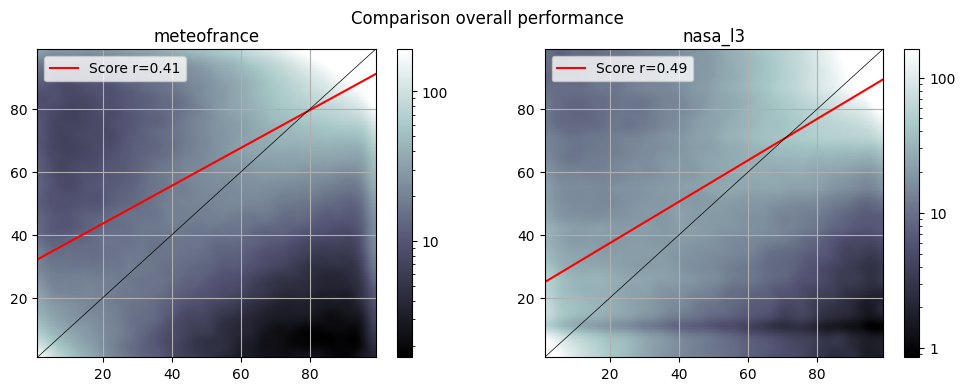

In [4]:
fig, ax = plt.subplots(1,len(analyses_dict), figsize=(12,4))
fig.suptitle('Comparison overall performance')
for i, (k,v) in enumerate(analyses_dict.items()):
    reduced_v = v.sel(ref_bins=slice(1,99),forest_mask=[0],test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
    fancy_scatter_plot(data_to_plt=reduced_v, ax=ax[i], figure=fig)
    ax[i].set_title(k)



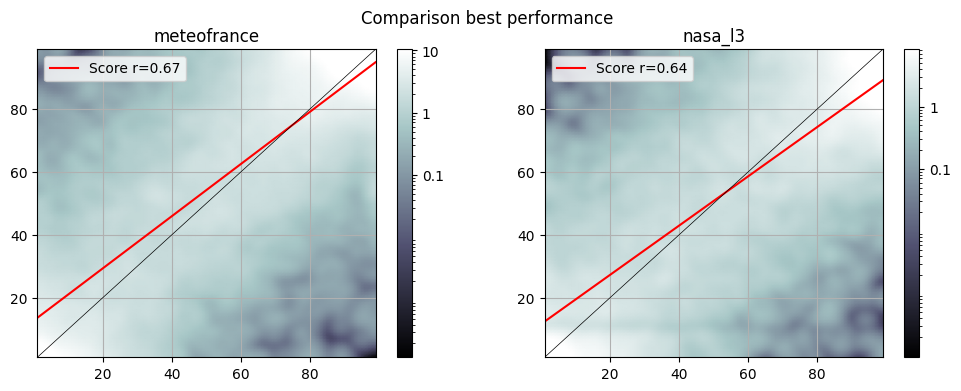

In [5]:
fig, ax = plt.subplots(1,len(analyses_dict), figsize=(12,4))
fig.suptitle('Comparison best performance')
for i, (k,v) in enumerate(analyses_dict.items()):
    reduced_v = v.sel(ref_bins=slice(1,99),forest_mask=[0], sub_roi=[2], aspect_bins=['SW','S','SE'],time='2024-02',test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
    fancy_scatter_plot(data_to_plt=reduced_v, ax=ax[i], figure=fig)
    ax[i].set_title(k)

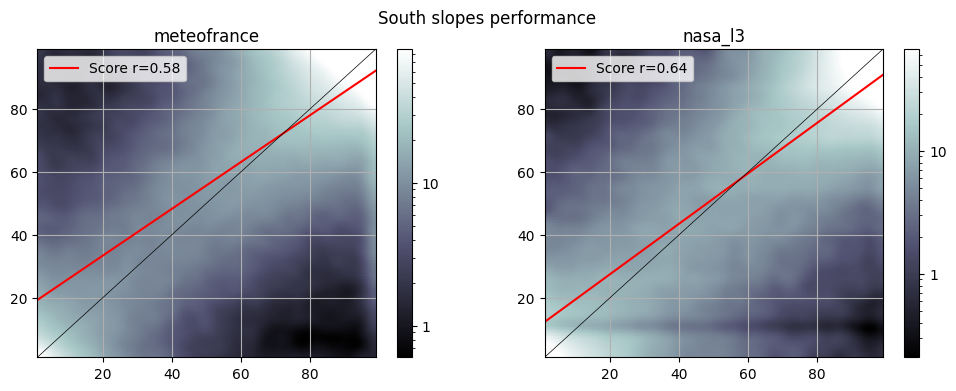

In [6]:
fig, ax = plt.subplots(1,len(analyses_dict), figsize=(12,4))
fig.suptitle('South slopes performance')
for i, (k,v) in enumerate(analyses_dict.items()):
    reduced_v = v.sel(ref_bins=slice(1,99),forest_mask=[0],aspect_bins=['SE','S','SW'],test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
    fancy_scatter_plot(data_to_plt=reduced_v, ax=ax[i], figure=fig)
    ax[i].set_title(k)

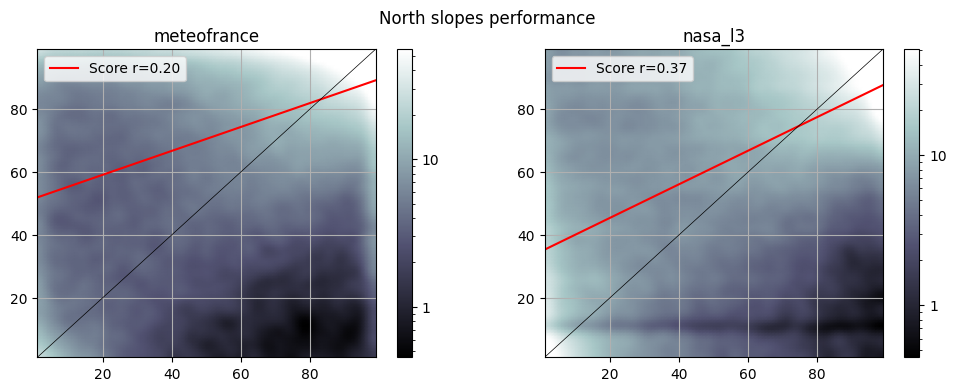

In [7]:
fig, ax = plt.subplots(1,len(analyses_dict), figsize=(12,4))
fig.suptitle('North slopes performance')
for i, (k,v) in enumerate(analyses_dict.items()):
    reduced_v = v.sel(ref_bins=slice(1,99),forest_mask=[0],aspect_bins=['NE','N','NW'],test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
    fancy_scatter_plot(data_to_plt=reduced_v, ax=ax[i], figure=fig)
    ax[i].set_title(k)

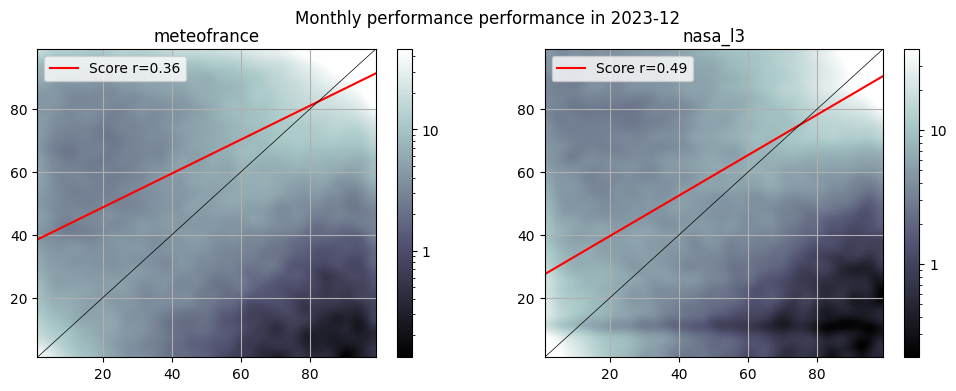

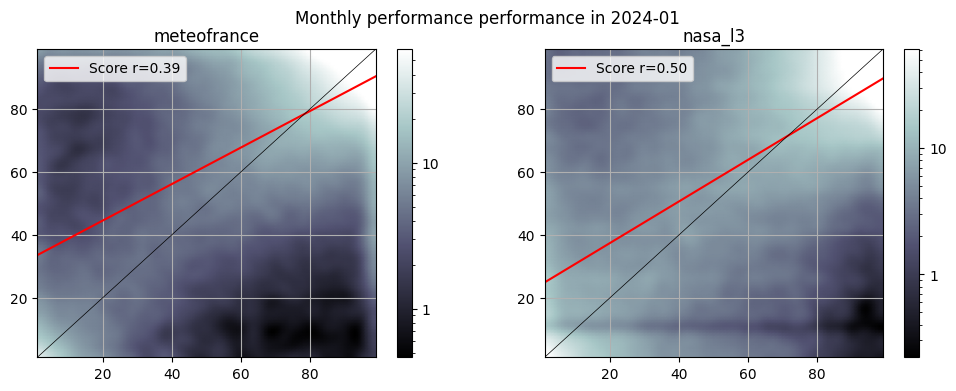

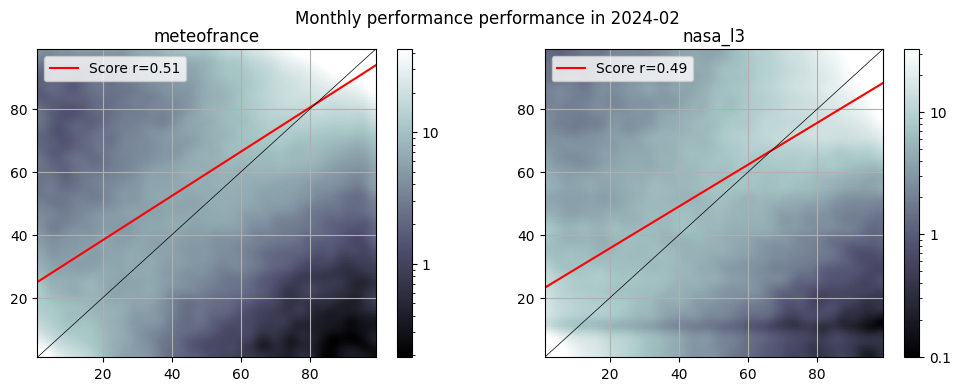

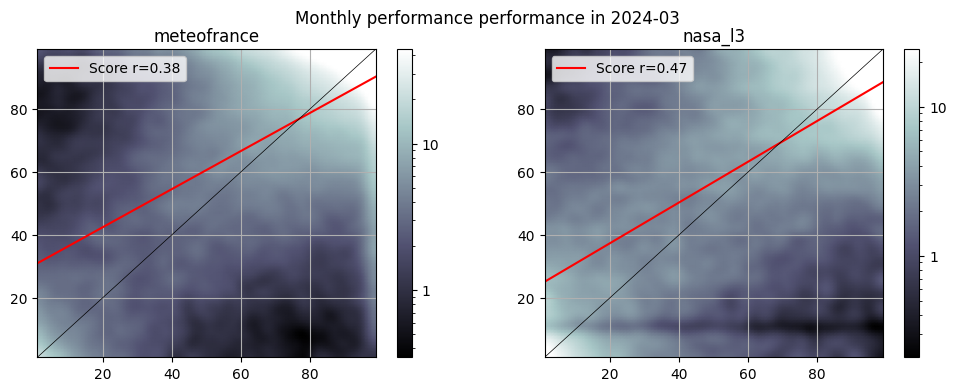

In [8]:
for t in ['2023-12', '2024-01', '2024-02', '2024-03']:
    fig, ax = plt.subplots(1,len(analyses_dict), figsize=(12,4))
    fig.suptitle(f'Monthly performance performance in {t}')
    for i, (k,v) in enumerate(analyses_dict.items()):
        reduced_v = v.sel(ref_bins=slice(1,99),forest_mask=[0],time=t,test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
        fancy_scatter_plot(data_to_plt=reduced_v, ax=ax[i], figure=fig)
        ax[i].set_title(k)

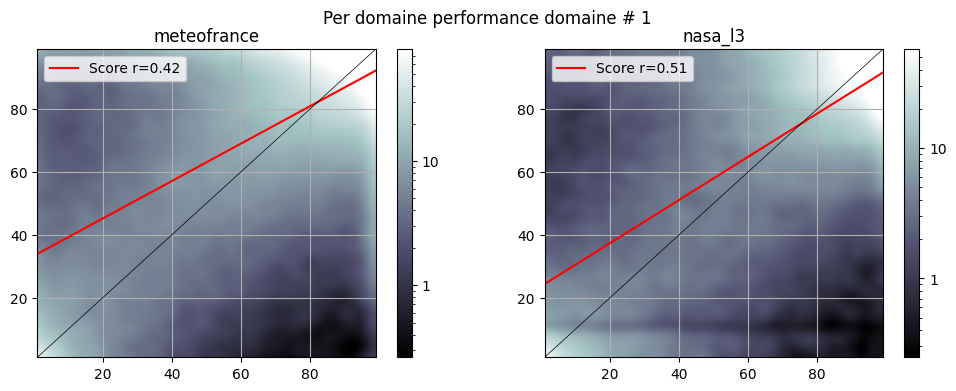

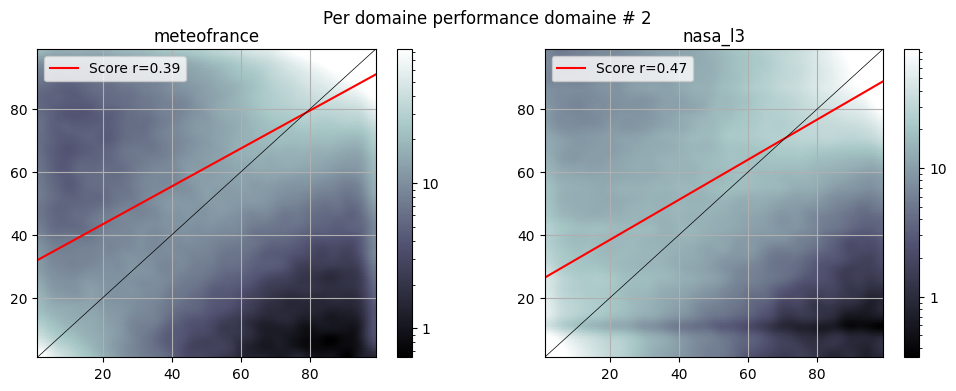

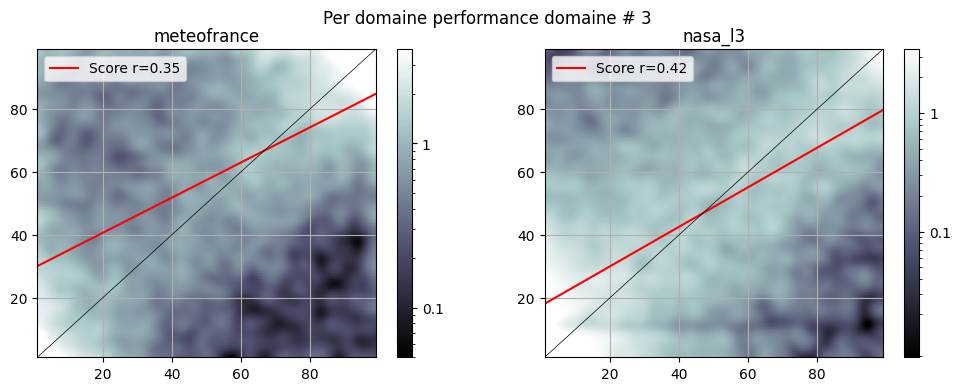

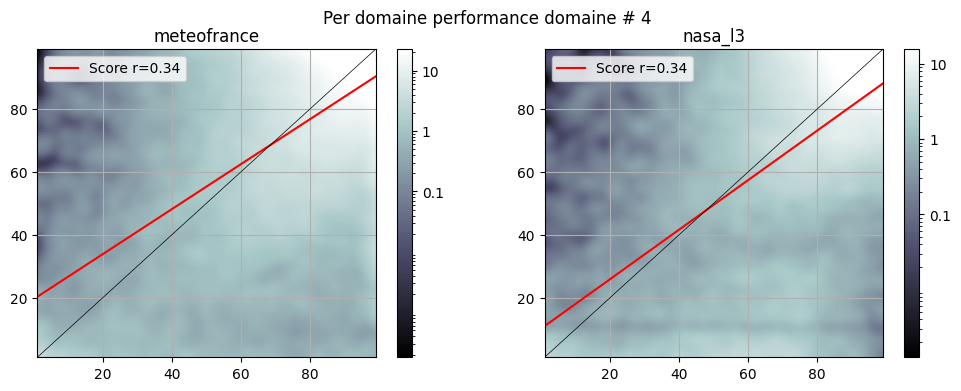

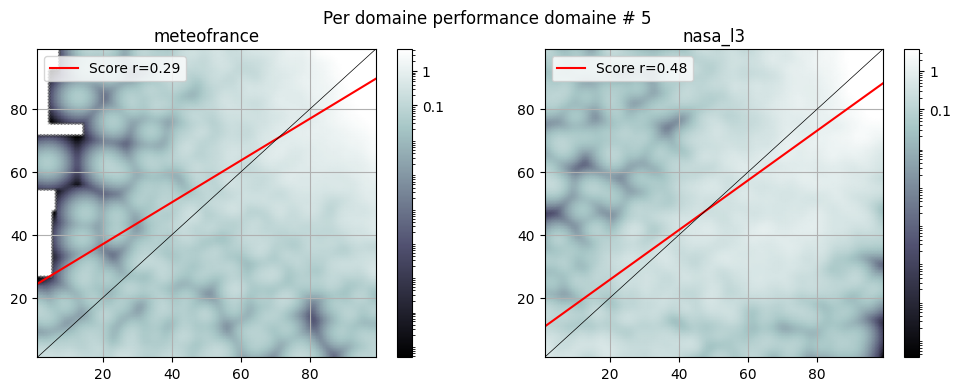

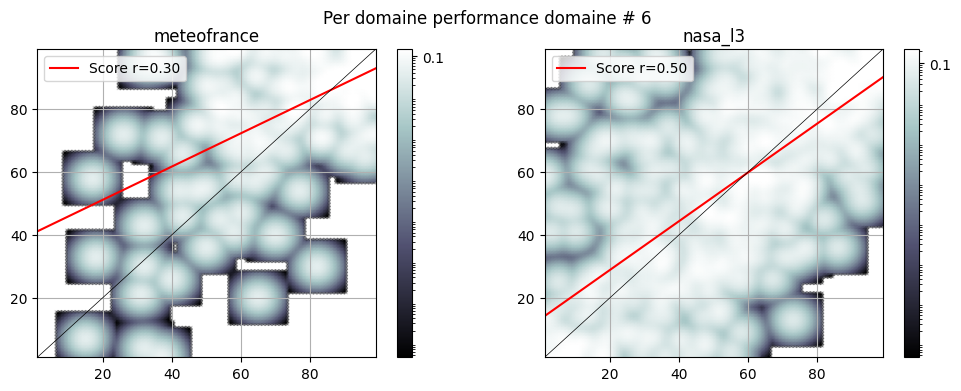

In [9]:
for d in [1,2,3,4,5,6]:
    fig, ax = plt.subplots(1,len(analyses_dict), figsize=(12,4))
    fig.suptitle(f'Per domaine performance domaine # {d}')
    for i, (k,v) in enumerate(analyses_dict.items()):
        reduced_v = v.sel(ref_bins=slice(1,99),forest_mask=[0],sub_roi=[d],test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
        fancy_scatter_plot(data_to_plt=reduced_v, ax=ax[i], figure=fig)
        ax[i].set_title(k)

Text(0, 0.5, 'TEST')

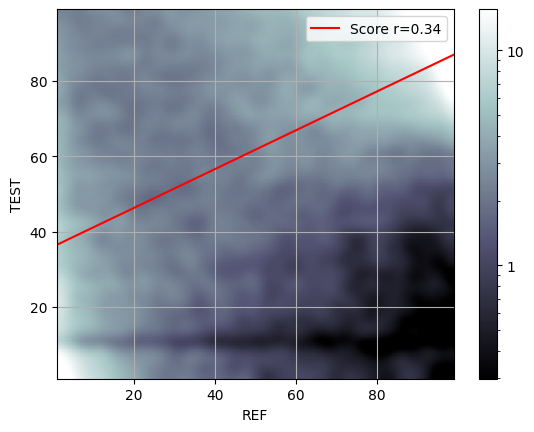

In [ ]:
from matplotlib.patches import Patch 


def fit_regression(data_to_fit: xr.DataArray):
    test_grid, ref_grid = np.meshgrid(data_to_fit.ref_bins.values, data_to_fit.test_bins.values)
    regression = LinearRegression().fit( ref_grid.reshape((-1,1)),test_grid.reshape((-1,1)), data_to_fit.values.ravel())
    return regression.coef_[0], regression.intercept_, regression.score(ref_grid.reshape((-1,1)), test_grid.reshape((-1,1)), data_to_fit.values.ravel())

def fancy_scatter_plot(data_to_plt: xr.DataArray, ax: Axes,figure: Figure, s=2):
    data_smooth=gaussian_filter(data_to_plt, sigma=s)
    distr_min, distr_max = np.quantile(data_smooth,0.02), np.quantile(data_smooth,0.98)
    a,b,score=fit_regression(data_to_plt)
    scatter_plot = ax.pcolormesh(data_to_plt.ref_bins.values,
                                 data_to_plt.test_bins.values,
                                 data_smooth.T,
                                 norm=colors.LogNorm(vmin=distr_min,vmax=distr_max),
                                 shading='gouraud',cmap=cm.bone)
    regression_x_axis = data_to_plt.ref_bins.values
    ax.plot(regression_x_axis, regression_x_axis*a + b , color='r')
    ax.grid(True)
    cbar_ticks = np.array([1e-1,1,1e1,1e2,1e3,1e4])
    cbar = figure.colorbar(scatter_plot, ticks=cbar_ticks)
    cbar.ax.set_yticklabels([f'{tick:n}' for tick in cbar_ticks]) 
    ax.legend([f'Score r={score:.2f}'])
    

fig, ax = plt.subplots()
reduced_alps = nasa_l3_metrics_ds.sel(ref_bins=slice(1,99),forest_mask=[0],aspect_bins=np.array(['N']),test_bins=slice(1,99)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']


fancy_scatter_plot(reduced_alps, ax, fig)
ax.set_xlabel('REF')
ax.set_ylabel('TEST')

In [512]:
reduced_alps.loc[dict(ref_bins=89, test_bins=20)]

<xarray.DataArray 'n_occurrences' ()> Size: 8B
array(0.)
Coordinates:
    ref_bins   int64 8B 89
    test_bins  int64 8B 20
    quantile   float64 8B 0.8

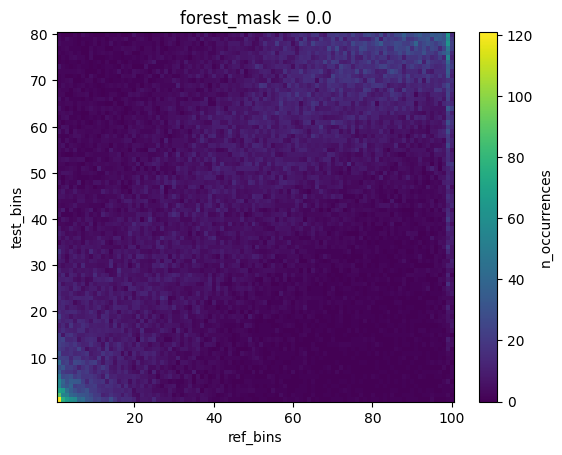

In [465]:
reduced_alps=mf_metrics_ds.sel(ref_bins=slice(1,100),forest_mask=0,aspect_bins=np.array(['S','SW']),test_bins=slice(1,80)).sum(dim=('sub_roi','time','aspect_bins')).data_vars['n_occurrences']
reduced_alps.plot.imshow(x='ref_bins')

In [462]:
reduced_alps.values

array([[33., 27., 14., ...,  8.,  3.,  7.],
       [26., 11., 11., ...,  8.,  4.,  3.],
       [18., 14., 15., ...,  5.,  3.,  5.],
       ...,
       [ 1.,  0.,  2., ..., 15., 12., 19.],
       [ 0.,  0.,  0., ..., 16., 14., 20.],
       [ 0.,  0.,  1., ..., 15., 10., 16.]])

In [446]:
fake_data_array.sel(test_bins=2)

<xarray.DataArray (ref_bins: 95)> Size: 760B
array([3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3])
Coordinates:
  * ref_bins   (ref_bins) int64 760B 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
    test_bins  int64 8B 2

In [400]:
xx

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [97, 97, 97, ..., 97, 97, 97],
       [98, 98, 98, ..., 98, 98, 98],
       [99, 99, 99, ..., 99, 99, 99]])

In [399]:
yy

array([[ 1,  2,  3, ..., 97, 98, 99],
       [ 1,  2,  3, ..., 97, 98, 99],
       [ 1,  2,  3, ..., 97, 98, 99],
       ...,
       [ 1,  2,  3, ..., 97, 98, 99],
       [ 1,  2,  3, ..., 97, 98, 99],
       [ 1,  2,  3, ..., 97, 98, 99]])

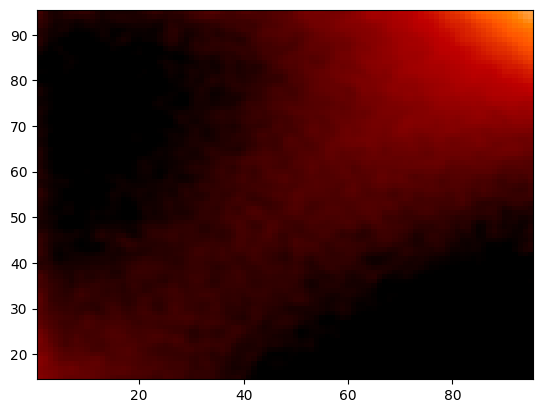

In [124]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def fancy_scatter_plot(data_to_plt: xr.DataArray):
    data_normalized = data_to_plt#/data_to_plt.sum(dim='test_bins')
    data_smooth=gaussian_filter(data_normalized, sigma=1)
    plt.pcolormesh(data_to_plt.ref_bins, data_to_plt.test_bins, np.log10(data_smooth.T), vmin=1,vmax=3,cmap='gist_heat')

reduced_alps = mf_metrics_ds.sel(ref_bins=slice(1,95),test_bins=slice(15,95)).sum(dim=('forest_mask','sub_roi','time','aspect_bins')).data_vars['n_occurrences']
fancy_scatter_plot(reduced_alps)

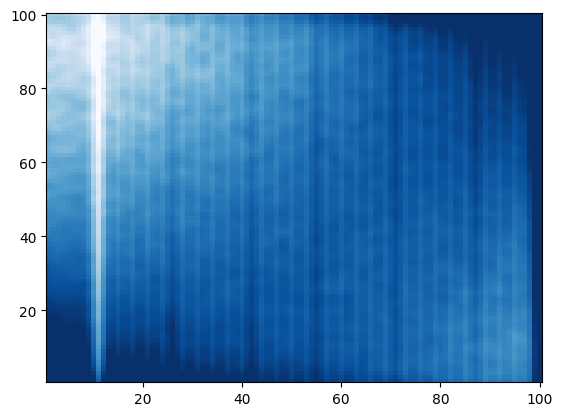

In [97]:
def fancy_scatter_plot(data_to_plt: xr.DataArray):
    data_normalized = data_to_plt#/data_to_plt.sum(dim='test_bins')
    data_smooth=gaussian_filter(data_normalized, sigma=1)
    plt.pcolormesh(data_to_plt.ref_bins, data_to_plt.test_bins, np.log10(data_smooth), vmin=0.01,vmax=1.9,cmap='Blues')

reduced_alps = nasa_l3_metrics_ds.sel(forest_mask=1,ref_bins=slice(1,100),test_bins=slice(1,100)).sum(dim=('sub_roi','time','aspect_bins')).data_vars['n_occurrences']
fancy_scatter_plot(reduced_alps)

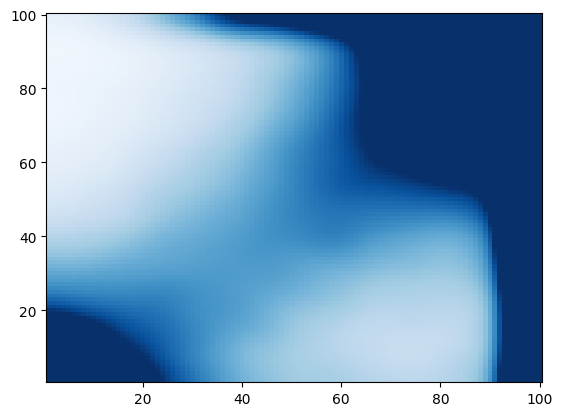

In [77]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def fancy_scatter_plot(data_to_plt: xr.DataArray):
    data_normalized = data_to_plt#/data_to_plt.sum(dim='test_bins')
    data_smooth=gaussian_filter(data_normalized, sigma=4)
    plt.pcolormesh(data_to_plt.ref_bins, data_to_plt.test_bins, data_smooth, vmin=0.01,vmax=12,cmap='Blues')

fancy_scatter_plot(reduced_alps)

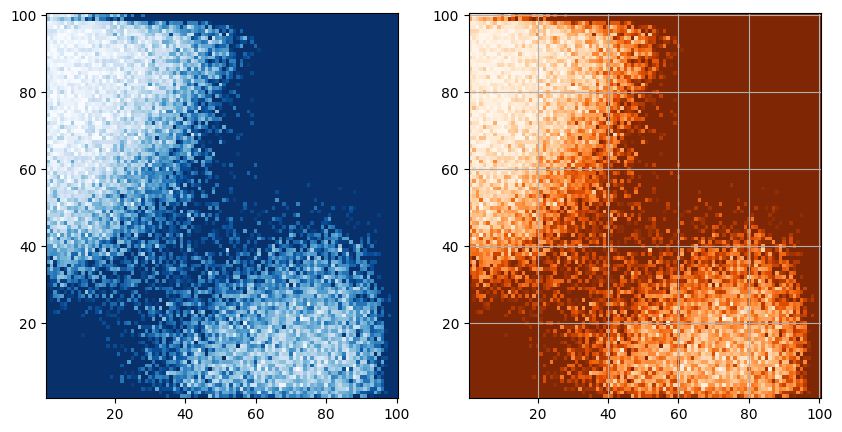

In [100]:
import numpy as np
fig,ax =plt.subplots(1,2, figsize=(10,5))
reduced_alps = mf_metrics_ds.sel(ref_bins=slice(1,100),test_bins=slice(1,100)).sum(dim=('sub_roi','time','forest_mask','aspect_bins')).data_vars['n_occurrences']
reduced_pyr = mf_metrics_ds.sel(ref_bins=slice(1,100),test_bins=slice(1,100)).sum(dim=('sub_roi','time','forest_mask','aspect_bins')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_alps.ref_bins, reduced_alps.test_bins, reduced_alps,vmin=1, vmax=20, cmap='Blues')
ax[1].pcolormesh(reduced_pyr.ref_bins, reduced_pyr.test_bins, reduced_pyr,vmin=1, vmax=20, cmap='Oranges')
ax[1].grid(True)

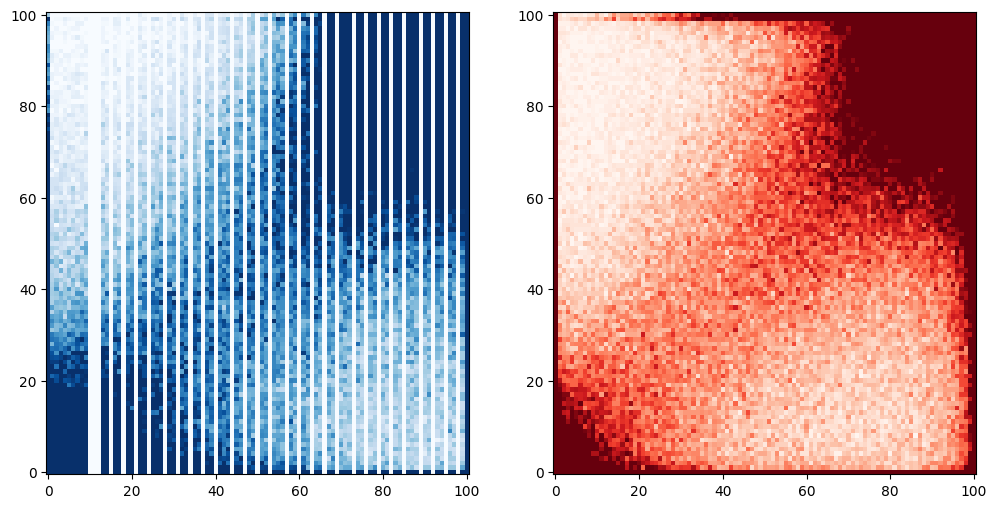

In [95]:
fig,ax =plt.subplots(1,2,figsize=(12,6))
reduced_nasa_l3 = nasa_l3_metrics_ds.sel(forest_mask=0,ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
reduced_meteofrance = mf_metrics_ds.sel(forest_mask=0,ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_nasa_l3.ref_bins, reduced_nasa_l3.test_bins, reduced_nasa_l3,vmin=1, vmax=40, cmap='Blues')
ax[1].pcolormesh(reduced_meteofrance.ref_bins, reduced_meteofrance.test_bins, reduced_meteofrance,vmin=1, vmax=40, cmap='Reds')


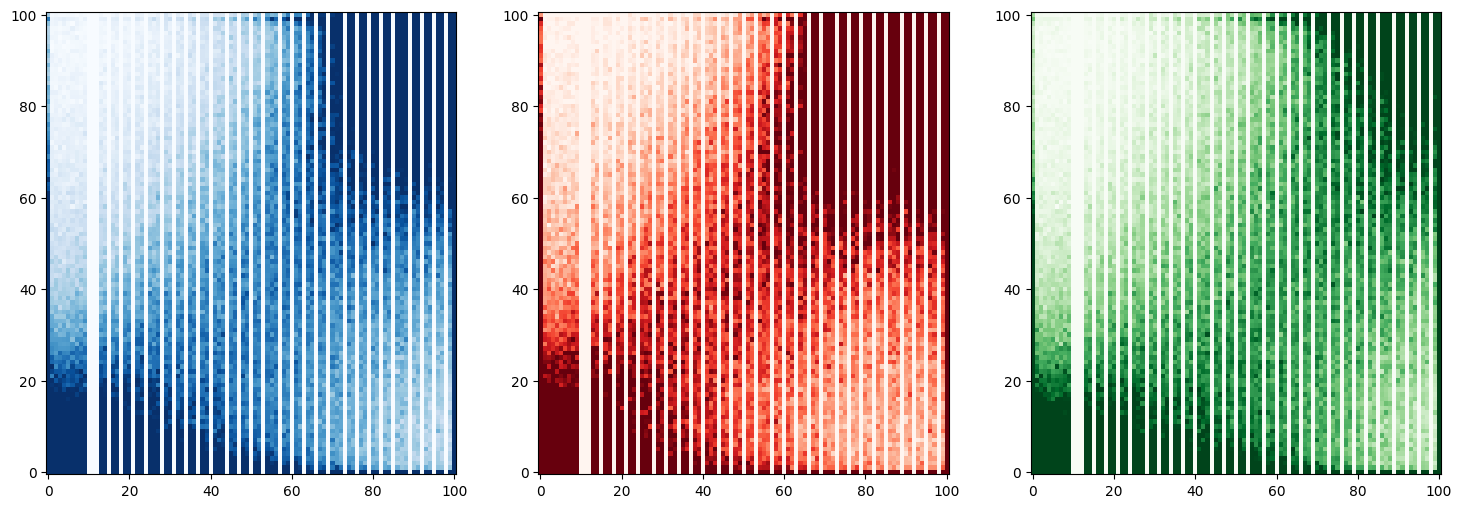

In [104]:
fig,ax =plt.subplots(1,3,figsize=(18,6))
reduced_nasa_l3_all = nasa_l3_metrics_ds.sel(ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('forest_mask','time','sub_roi','aspect_bins')).data_vars['n_occurrences']
reduced_nasa_l3_no_forest = nasa_l3_metrics_ds.sel(forest_mask=0,ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
reduced_nasa_l3_forest = nasa_l3_metrics_ds.sel(forest_mask=1,ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_nasa_l3_all.ref_bins, reduced_nasa_l3_all.test_bins, reduced_nasa_l3_all,vmin=1, vmax=120, cmap='Blues')
ax[1].pcolormesh(reduced_nasa_l3_no_forest.ref_bins, reduced_nasa_l3_no_forest.test_bins, reduced_nasa_l3_no_forest,vmin=1, vmax=40, cmap='Reds')
ax[2].pcolormesh(reduced_nasa_l3_forest.ref_bins, reduced_nasa_l3_forest.test_bins, reduced_nasa_l3_forest,vmin=1, vmax=80, cmap='Greens')

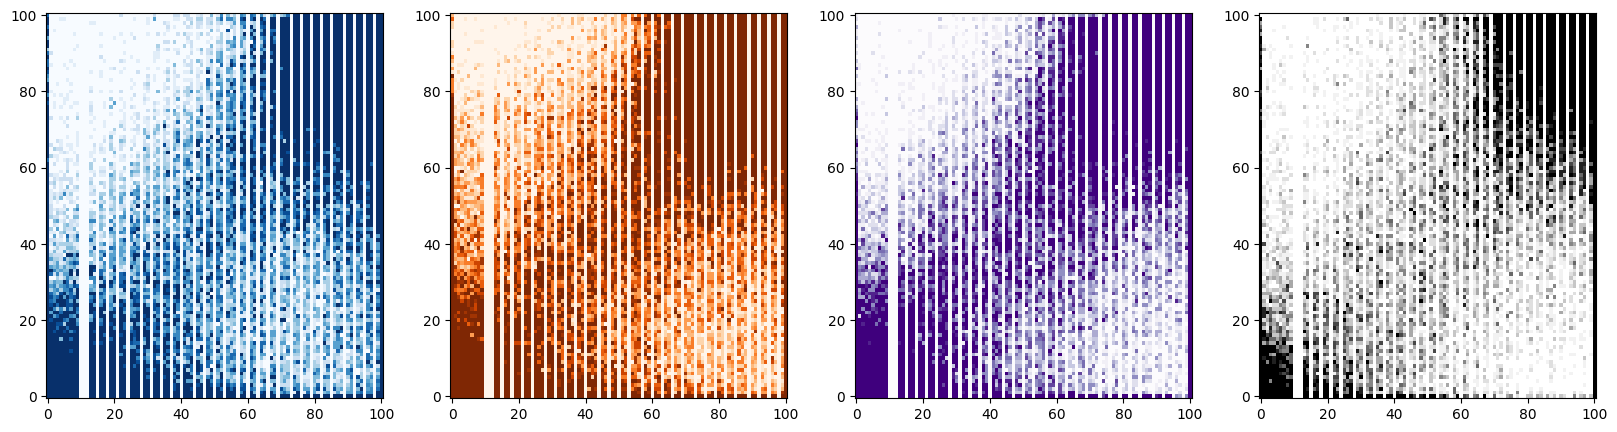

In [87]:
import numpy as np
fig,ax =plt.subplots(1,4, figsize=(20,5))
reduced_dec = nasa_l3_metrics_ds.sel(forest_mask=0,time='2023-12',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
reduced_jan = nasa_l3_metrics_ds.sel(forest_mask=0,time='2024-01',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
reduced_feb = nasa_l3_metrics_ds.sel(forest_mask=0,time='2024-02',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
reduced_mars = nasa_l3_metrics_ds.sel(forest_mask=0,time='2024-03',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','aspect_bins')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_dec.ref_bins, reduced_dec.test_bins, reduced_dec,vmin=1, vmax=10, cmap='Blues')
ax[1].pcolormesh(reduced_pyr.ref_bins, reduced_pyr.test_bins, reduced_jan,vmin=1, vmax=10, cmap='Oranges')
ax[2].pcolormesh(reduced_dec.ref_bins, reduced_dec.test_bins, reduced_feb,vmin=1, vmax=10, cmap='Purples')
ax[3].pcolormesh(reduced_pyr.ref_bins, reduced_pyr.test_bins, reduced_mars,vmin=1, vmax=10, cmap='Greys')

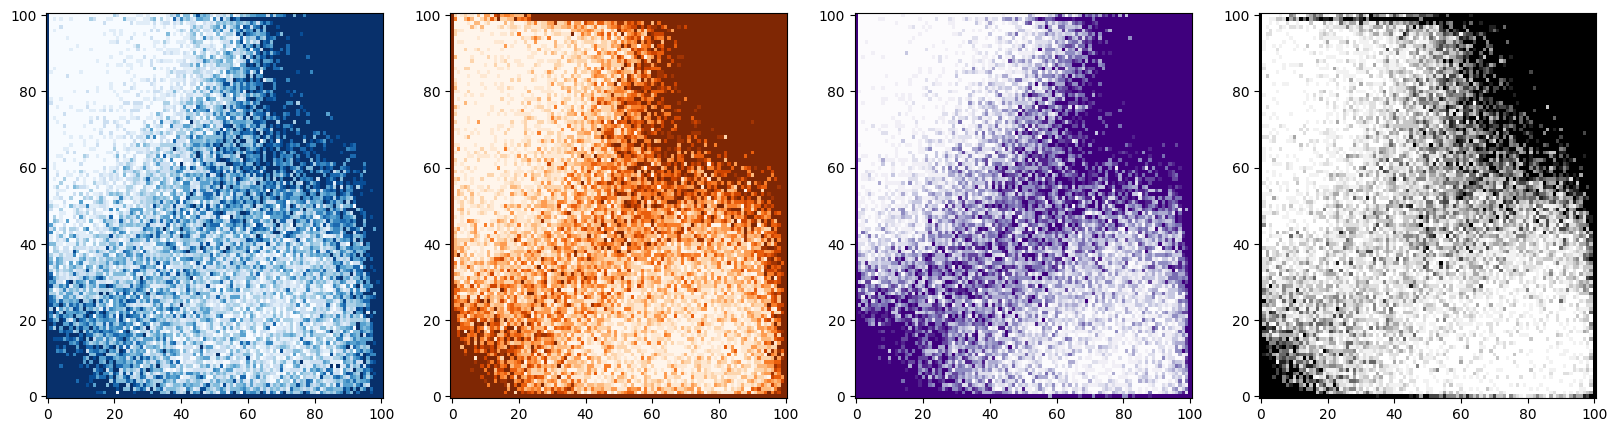

In [76]:
import numpy as np
fig,ax =plt.subplots(1,4, figsize=(20,5))
reduced_dec = mf_metrics_ds.sel(time='2023-12',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','forest_mask','aspect_bins')).data_vars['n_occurrences']
reduced_jan = mf_metrics_ds.sel(time='2024-01',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','forest_mask','aspect_bins')).data_vars['n_occurrences']
reduced_feb = mf_metrics_ds.sel(time='2024-02',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','forest_mask','aspect_bins')).data_vars['n_occurrences']
reduced_mars = mf_metrics_ds.sel(time='2024-03',ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','sub_roi','forest_mask','aspect_bins')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_dec.ref_bins, reduced_dec.test_bins, reduced_dec,vmin=1, vmax=10, cmap='Blues')
ax[1].pcolormesh(reduced_pyr.ref_bins, reduced_pyr.test_bins, reduced_jan,vmin=1, vmax=10, cmap='Oranges')
ax[2].pcolormesh(reduced_dec.ref_bins, reduced_dec.test_bins, reduced_feb,vmin=1, vmax=10, cmap='Purples')
ax[3].pcolormesh(reduced_pyr.ref_bins, reduced_pyr.test_bins, reduced_mars,vmin=1, vmax=10, cmap='Greys')

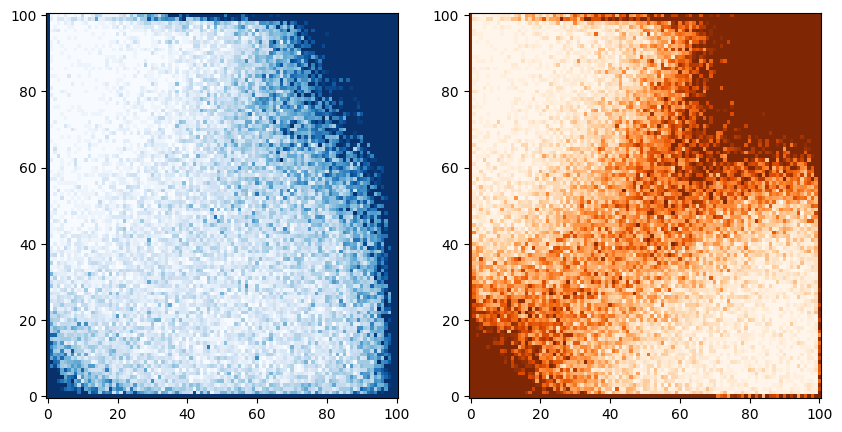

In [81]:
import numpy as np
fig,ax =plt.subplots(1,2, figsize=(10,5))
reduced_nord = mf_metrics_ds.sel(aspect_bins=np.array(['N','NW', 'NE']),ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','aspect_bins','forest_mask', 'sub_roi')).data_vars['n_occurrences']
reduced_sud = mf_metrics_ds.sel(aspect_bins=np.array(['S','SW', 'SE']),ref_bins=slice(0,101),test_bins=slice(0,101)).sum(dim=('time','aspect_bins','forest_mask', 'sub_roi')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_nord.ref_bins, reduced_nord.test_bins, reduced_nord,vmin=1, vmax=20, cmap='Blues')
ax[1].pcolormesh(reduced_nord.ref_bins, reduced_nord.test_bins, reduced_sud,vmin=1, vmax=20, cmap='Oranges')

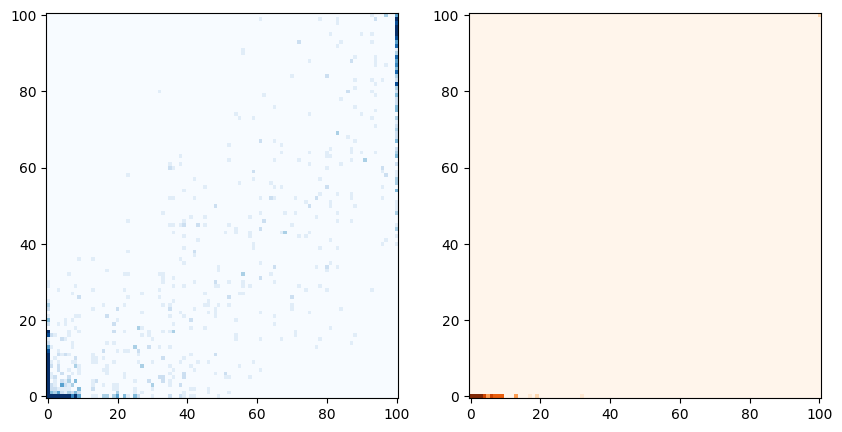

In [57]:
import numpy as np
fig,ax =plt.subplots(1,2, figsize=(10,5))
reduced_alps = nasa_l3_metrics_ds.sel(sub_roi=5,ref_bins=slice(0,101)).sum(dim=('time','forest_mask','aspect_bins')).data_vars['n_occurrences']
reduced_pyr = nasa_l3_metrics_ds.sel(sub_roi=6,ref_bins=slice(0,101)).sum(dim=('time','forest_mask','aspect_bins')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_alps.ref_bins, reduced_alps.test_bins, reduced_alps,vmin=1, vmax=10, cmap='Blues')
ax[1].pcolormesh(reduced_pyr.ref_bins, reduced_pyr.test_bins, reduced_pyr,vmin=1, vmax=10, cmap='Oranges')

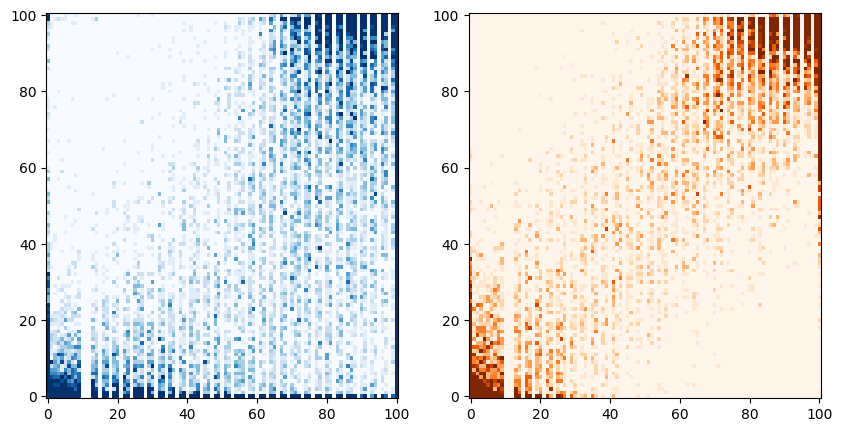

In [52]:
import numpy as np
fig,ax =plt.subplots(1,2, figsize=(10,5))
reduced_nord = nasa_l3_metrics_ds.sel(aspect_bins=np.array(['N','NW', 'NE']),ref_bins=slice(0,101)).sum(dim=('time','forest_mask','aspect_bins', 'sub_roi')).data_vars['n_occurrences']
reduced_sud = nasa_l3_metrics_ds.sel(aspect_bins=np.array(['S','SW', 'SE']),ref_bins=slice(0,101)).sum(dim=('time','forest_mask','aspect_bins', 'sub_roi')).data_vars['n_occurrences']
ax[0].pcolormesh(reduced_nord.ref_bins, reduced_nord.test_bins, reduced_nord,vmin=1, vmax=10, cmap='Blues')
ax[1].pcolormesh(reduced_nord.ref_bins, reduced_nord.test_bins, reduced_sud,vmin=1, vmax=10, cmap='Oranges')


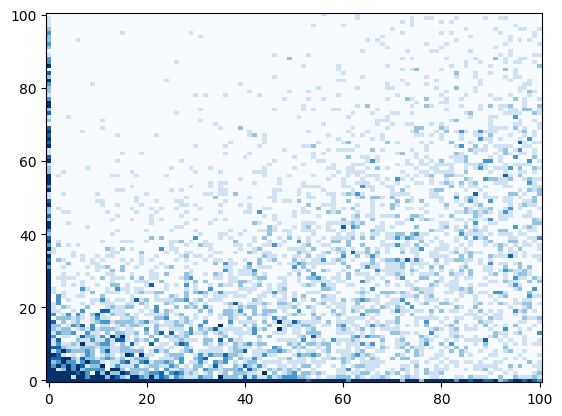

In [11]:
reduced = mf_metrics_ds.sel(ref_bins=slice(0,101)).sum(dim=('aspect_bins', 'time', 'forest_mask', 'sub_roi')).data_vars['n_occurrences']
plt.pcolormesh(reduced.ref_bins, reduced.test_bins, reduced,vmin=0, vmax=5, cmap='Blues')

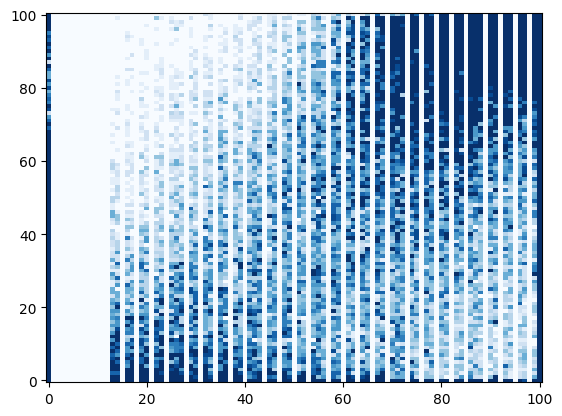

In [13]:
reduced = nasa_pseudo_l3_metrics_ds.sel(ref_bins=slice(0,101)).sum(dim=('aspect_bins', 'time', 'forest_mask', 'sub_roi')).data_vars['n_occurrences']
plt.pcolormesh(reduced.ref_bins, reduced.test_bins, reduced,vmin=0, vmax=10, cmap='Blues')

OLD CODE THAT WILL HAVE TO DIE

In [1]:
import rasterio as rio
import glob as glob
import xarray as xr
import datetime as datetime
import numpy as np
import xarray as xr
from pathlib import Path
from winter_year import WinterYear
import pandas as pd

winter_year = WinterYear(2023, 2024)
time_series_folder = '../output_folder/cms_workshop'


In [2]:
s2_filename = 'WY_2023_2024_S2_res_250m_time_series.nc'
mf_filename = 'WY_2023_2024_SuomiNPP_meteofrance_time_series.nc'
nasa_filename = 'WY_2023_2024_SuomiNPP_nasa_fsc_time_series.nc'
s2_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(s2_filename))
meteofrance_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(mf_filename))
nasa_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_filename))

In [3]:
from scipy.ndimage import gaussian_filter
def myplot(x, y, s, bins=100):

    heatmap, xedges, yedges = np.histogram2d(x.values.flatten(), y.values.flatten(), bins=bins, range=[[0,100],[0,100]])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = np.array([xedges[0], xedges[-1], yedges[0], yedges[-1]])
    return heatmap.T, extent


In [4]:
import random
from  matplotlib.pyplot import cm
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter
formatter = LogFormatter(base=10, labelOnlyBase=False)
common1 = np.intersect1d(meteofrance_time_series["time"], s2_time_series["time"])
common_2 = np.intersect1d(common1, nasa_time_series["time"])
common_days = common_2[90:110]
colorsmap = cm.hot_r
colorsmap.set_under('w')

KeyboardInterrupt: 

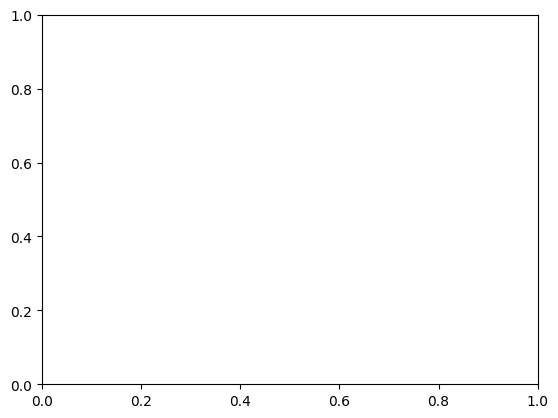

In [5]:
import matplotlib.pyplot as plt
from  matplotlib.pyplot import cm
import matplotlib.colors as colors
nasa = nasa_time_series.data_vars['snow_cover'].sel(time=common_days)
nasa = nasa.where(nasa<100)
nasa = nasa.where(nasa!=0)
# nasa = nasa*1.45 - 0.01
# nasa = xr.where(nasa<100, nasa, 100)
# nasa = xr.where(nasa!=0, nasa, 0)
mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=common_days)
mf = mf.where(mf<200 )*0.5
mf = mf.where(mf!=0)

fig, ax = plt.subplots()

img, extent = myplot(nasa, mf, 5,bins=50)

pos = ax.imshow(img, extent=list(extent), origin='lower', cmap=colorsmap, norm=colors.LogNorm(vmin=20, vmax=500))
fig.colorbar(pos, ax=ax)
ax.set_xlabel('nasa')
ax.set_ylabel('météo-france')
ax.grid(True)

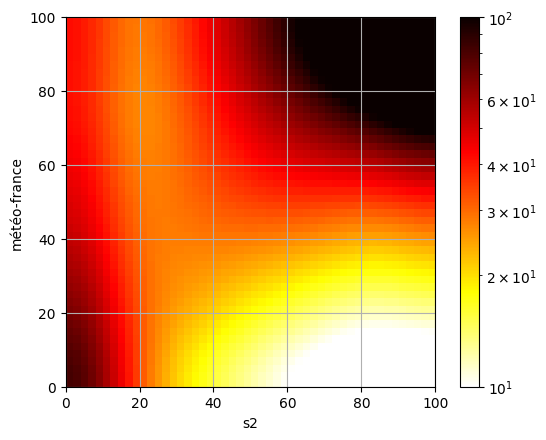

In [82]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm
import random


mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=common_days)
mf = mf.where(mf<200 )*0.5
mf = mf.where(mf!=0)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2.where(s2<100)

fig, ax = plt.subplots()

img, extent = myplot(s2, mf, 5, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap, norm=colors.LogNorm(vmin=10, vmax=100))
fig.colorbar(pos, ax=ax)
ax.set_xlabel('s2')
ax.set_ylabel('météo-france')
ax.grid(True)


Text(0, 0.5, 'nasa')

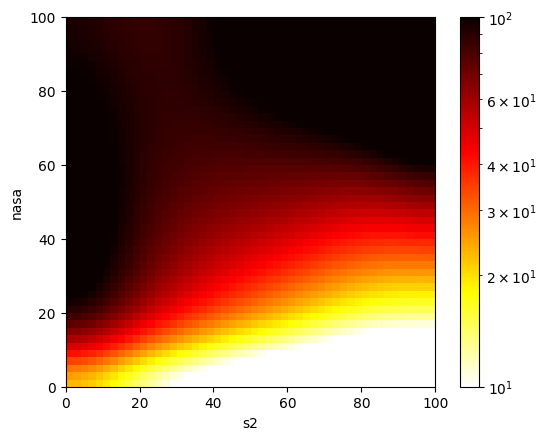

In [83]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

nasa = nasa_time_series.data_vars['snow_cover'].sel(time=common_days)
nasa = nasa.where(nasa<100)
nasa = nasa.where(nasa!=0)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2.where(s2<100)
s2 = s2.where(s2!=0)

fig, ax = plt.subplots()

img, extent = myplot(s2, nasa, 5,bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower', cmap=colorsmap, norm=colors.LogNorm(vmin=10, vmax=100))
fig.colorbar(pos, ax=ax)
ax.set_xlabel('s2')
ax.set_ylabel('nasa')


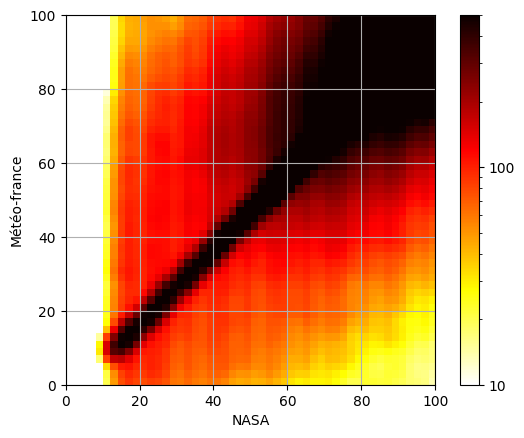

In [5]:
import matplotlib.pyplot as plt
from  matplotlib.pyplot import cm
import matplotlib.colors as colors
nasa = nasa_time_series.data_vars['snow_cover'].sel(time=common_days)
nasa = nasa.where(nasa<100)
nasa = nasa.where(nasa!=0)
# nasa = nasa*1.45 - 0.01
# nasa = xr.where(nasa<100, nasa, 100)
# nasa = xr.where(nasa!=0, nasa, 0)
mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=common_days)
mf = mf.where(mf<200 )*0.5
mf = mf.where(mf!=0)

fig, ax = plt.subplots()

img, extent = myplot(nasa, mf, 1,bins=50)

pos = ax.imshow(img, extent=list(extent), origin='lower', cmap=colorsmap, norm=colors.LogNorm(vmin=10, vmax=500))
fig.colorbar(pos, ax=ax, format=formatter)
ax.set_xlabel('NASA')
ax.set_ylabel('Météo-France')
ax.grid(True)

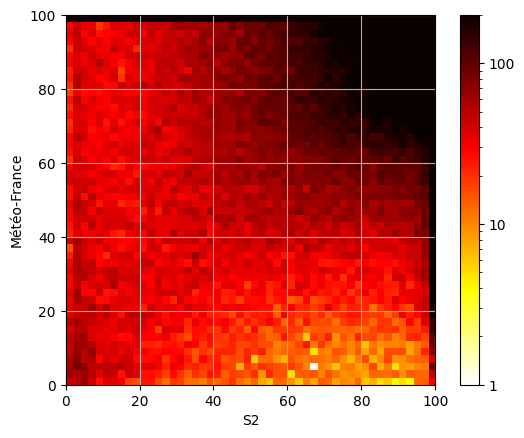

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm


mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
mf_forest_with_snow_mask = mf!=210
mf_mask = mf<=200
s2_mask = s2<=100
union_mask = mf_mask & s2_mask
mf_mask = mf!=0
s2_mask = s2!=0
union_mask_2 = mf_mask & s2_mask
union_mask = union_mask & union_mask_2
mf = mf.where(union_mask)*0.5
s2 = s2.where(union_mask)

fig, ax = plt.subplots()

img, extent = myplot(s2, mf, 0, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=200))
fig.colorbar(pos, ax=ax, format=formatter)
ax.set_xlabel('S2')
ax.set_ylabel('Météo-France')
ax.grid(True)

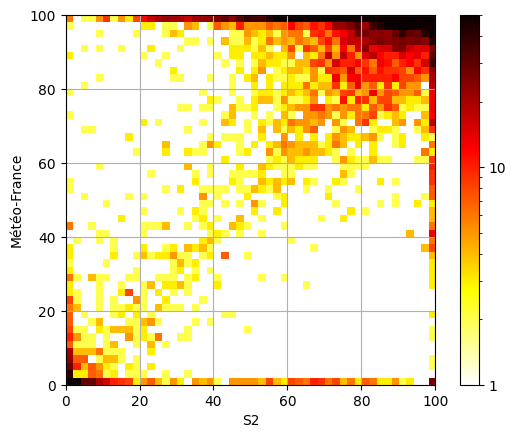

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm


mf = meteofrance_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
mf_mask = mf<=200
s2_mask = s2<=100
union_mask = mf_mask & s2_mask

mf = mf.where(union_mask)*0.5
s2 = s2.where(union_mask)

mf = mf.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)

fig, ax = plt.subplots()

img, extent = myplot(s2, mf, 0, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=50))
fig.colorbar(pos, ax=ax, format=formatter)
ax.set_xlabel('S2')
ax.set_ylabel('Météo-France')
ax.grid(True)

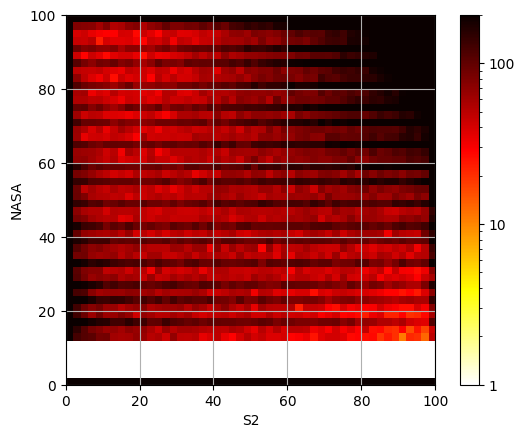

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm


nasa = nasa_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
nasa = nasa.where(mf_forest_with_snow_mask)
nasa_mask = nasa<=100
s2_mask = s2<=100
union_mask = nasa_mask & s2_mask
nasa = nasa.where(union_mask)
s2 = s2.where(union_mask)

fig, ax = plt.subplots()

img, extent = myplot(s2, nasa, 0, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=200))
fig.colorbar(pos, ax=ax, format=formatter)
ax.set_xlabel('S2')
ax.set_ylabel('NASA')
ax.grid(True)

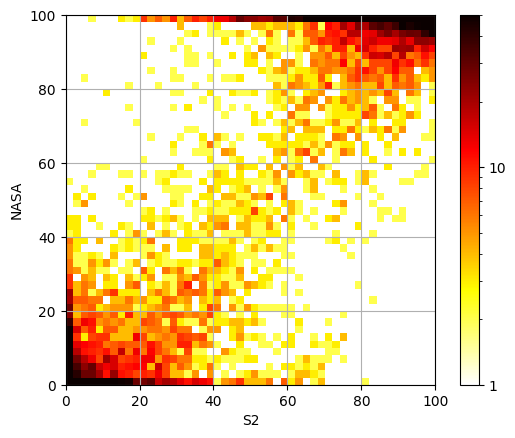

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm


nasa = nasa_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
nasa = nasa.where(mf_forest_with_snow_mask)
nasa_mask = nasa<=100
s2_mask = s2<=100
union_mask = nasa_mask & s2_mask
nasa = nasa.where(union_mask)
s2 = s2.where(union_mask)

nasa = nasa.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)
s2 = s2.astype(np.float32).coarsen(y=4,x=4, boundary='trim').mean(skipna=False)

fig, ax = plt.subplots()



img, extent = myplot(s2, nasa, 0, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=50))
fig.colorbar(pos, ax=ax, format=formatter)
ax.set_xlabel('S2')
ax.set_ylabel('NASA')
ax.grid(True)

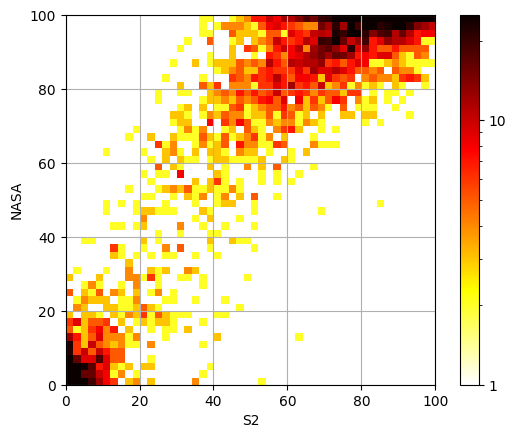

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm


nasa = nasa_time_series.data_vars['snow_cover'].sel(time=common_days)
s2 = s2_time_series.data_vars['snow_cover'].sel(time=common_days)
nasa_mask = nasa<=100
s2_mask = s2<=100
union_mask = nasa_mask & s2_mask
nasa = nasa.where(union_mask)
s2 = s2.where(union_mask)

nasa = nasa.astype(np.float32).coarsen(y=8,x=8, boundary='trim').mean(skipna=False)
s2 = s2.astype(np.float32).coarsen(y=8,x=8, boundary='trim').mean(skipna=False)

fig, ax = plt.subplots()



img, extent = myplot(s2, nasa, 0, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=25))
fig.colorbar(pos, ax=ax, format=formatter)
ax.set_xlabel('S2')
ax.set_ylabel('NASA')
ax.grid(True)

In [84]:
s2f = glob.glob('/home/imperatoren/work/VIIRS_S2_comparison/poc_resampling/FSC_20240130T105908_S2A_T31TCH_V102_1_FSCOG/*tif')[0]
s2_data = rio.open(s2f).read(1, masked=True)
#day = np.datetime64(datetime.datetime(year=2017, month=1, day=3))

vf = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/snow_cover_extent_analysis/WY_2023_2024_SuomiNPP_nasa_time_series.nc'
viirs = xr.open_dataset(vf).sel(time='2024-01-03')

In [85]:
A = viirs.data_vars['snow_cover']
viirs_masked = np.ma.masked_array(A, mask=A>=250)

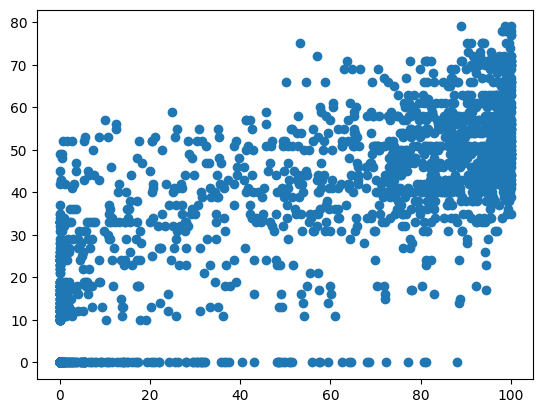

In [86]:
import matplotlib.pyplot as plt

plt.scatter(s2_data, viirs_masked)

In [3]:
from typing import List
import rasterio as rio
import glob as glob
import xarray as xr
import datetime as datetime
import numpy as np
import xarray as xr
from pathlib import Path
from winter_year import WinterYear
import pandas as pd
import matplotlib.pyplot as plt
winter_year = WinterYear(2023, 2024)
resolution=1000
time_series_folder = '../output_folder/version_3'
s2_filename = f'WY_2023_2024_S2_res_{resolution}m.nc'
mf_filename = f'WY_2023_2024_SNPP_meteofrance_res_{resolution}m.nc'
nasa_filename = f'WY_2023_2024_SNPP_nasa_l3_res_{resolution}m.nc'
nasa_pseudo_l3_filename = f'WY_2023_2024_SNPP_nasa_pseudo_l3_res_{resolution}m.nc'
s2_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(s2_filename))
meteofrance_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(mf_filename))
nasa_l3_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_filename))
nasa_pseudo_l3_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_pseudo_l3_filename))

def find_common_days(time_series_list: List[xr.Dataset]):
    common_days_old = time_series_list[0]["time"]
    for i in range(1,len(time_series_list)):
        common_days_new= np.intersect1d(common_days_old, time_series_list[i]["time"])
        common_days_old = common_days_new
    return common_days_new

common_days = find_common_days(time_series_list=[s2_time_series, meteofrance_time_series, nasa_pseudo_l3_time_series])
s2_time_series = s2_time_series.sel(time=common_days)
meteofrance_time_series = meteofrance_time_series.sel(time=common_days)
nasa_pseudo_l3_time_series = nasa_pseudo_l3_time_series.sel(time=common_days)


Text(0.5, 1.0, 'December 2023 - Resolution 1000 - NASA vs S2 (forest_included)')

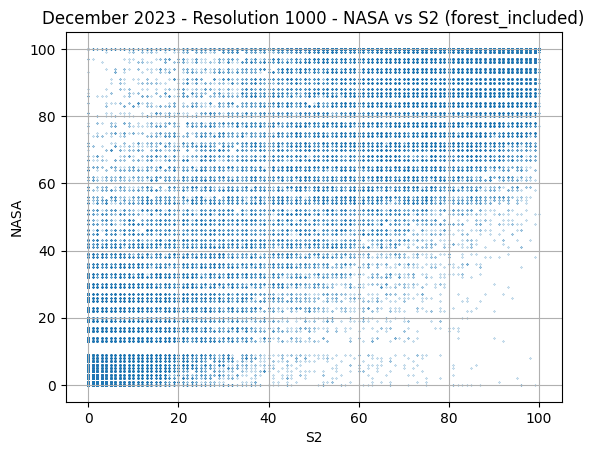

In [4]:
nasa = nasa_pseudo_l3_time_series.sel(time=common_days).sel(time='2023-12')
s2 = s2_time_series.sel(time=common_days).sel(time='2023-12')
nasa_mask = nasa.data_vars['snow_cover_fraction']<=100
s2_mask = s2.data_vars['snow_cover_fraction']<=100
union_mask = nasa_mask & s2_mask
nasa = nasa.data_vars['snow_cover_fraction'].where(union_mask)
s2 = s2.data_vars['snow_cover_fraction'].where(union_mask)

fig, ax = plt.subplots()
ax.scatter(s2, nasa, s=0.05)
ax.set_xlabel('S2')
ax.set_ylabel('NASA')
ax.grid(True)
ax.set_title(f'December 2023 - Resolution {resolution} - NASA vs S2 (forest_included)')

Text(0.5, 1.0, 'December 2023 - NASA vs S2 sensor zenith <45 (forest included)')

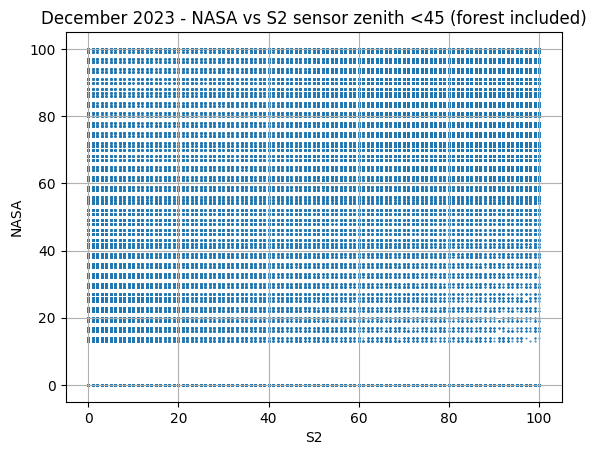

In [29]:
nasa = nasa_pseudo_l3_time_series.sel(time=common_days).sel(time='2023-12')
s2 = s2_time_series.sel(time=common_days).sel(time='2023-12')
nasa_mask = nasa.data_vars['snow_cover_fraction']<=100
s2_mask = s2.data_vars['snow_cover_fraction']<=100
nasa_mask_vza = nasa.data_vars['sensor_zenith']<=45
nasa_mask = nasa_mask & nasa_mask_vza
union_mask = nasa_mask & s2_mask
nasa = nasa.data_vars['snow_cover_fraction'].where(union_mask)
s2 = s2.data_vars['snow_cover_fraction'].where(union_mask)

fig, ax = plt.subplots()
ax.scatter(s2, nasa, s=0.05)
ax.set_xlabel('S2')
ax.set_ylabel('NASA')
ax.grid(True)
ax.set_title(f'December 2023 - Resolution {resolution} - NASA vs S2 sensor zenith <45 (forest included)')

Text(0.5, 1.0, 'December 2023 - Météo-France vs S2 (forest excluded)')

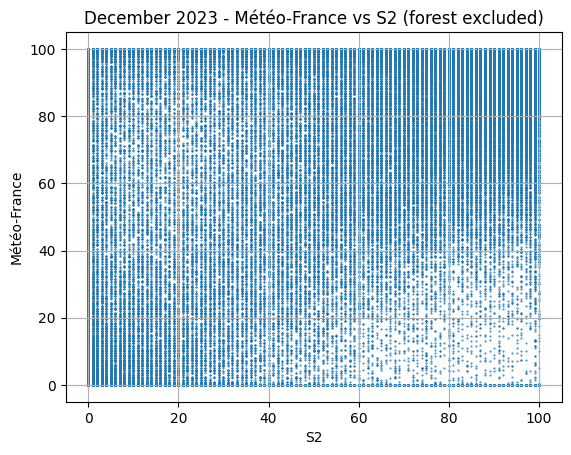

In [30]:
meteofrance = meteofrance_time_series.sel(time=common_days).sel(time='2023-12')
s2 = s2_time_series.sel(time=common_days).sel(time='2023-12')
meteofrance_mask = meteofrance.data_vars['snow_cover_fraction']<=200
s2_mask = s2.data_vars['snow_cover_fraction']<=100
union_mask = meteofrance_mask & s2_mask
meteofrance = meteofrance.data_vars['snow_cover_fraction'].where(union_mask) /2
s2 = s2.data_vars['snow_cover_fraction'].where(union_mask)

fig, ax = plt.subplots()
ax.scatter(s2, meteofrance, s=0.05)
ax.set_xlabel('S2')
ax.set_ylabel('Météo-France')
ax.grid(True)
ax.set_title(f'December 2023 - - Resolution {resolution} - Météo-France vs S2 (forest excluded)')

Text(0.5, 1.0, 'December 2023 - Resolution 1000 - Météo-France vs S2 sensor zenith < 45 (forest excluded)')

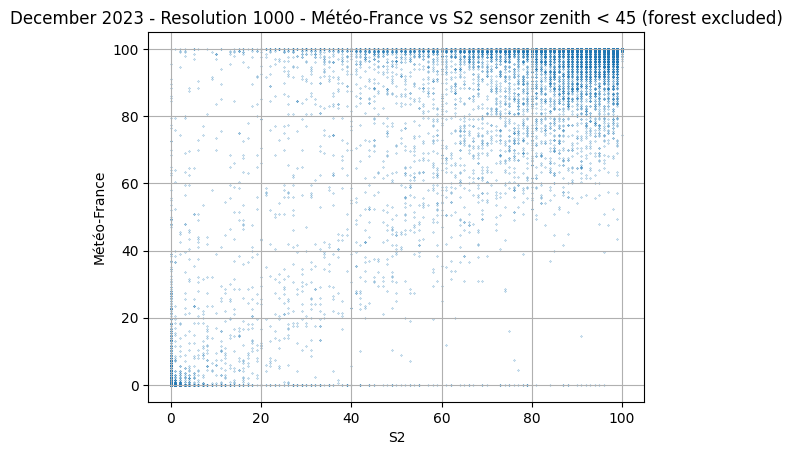

In [5]:
meteofrance = meteofrance_time_series.sel(time=common_days).sel(time='2023-12')
s2 = s2_time_series.sel(time=common_days).sel(time='2023-12')
meteofrance_mask = meteofrance.data_vars['snow_cover_fraction']<=200
s2_mask = s2.data_vars['snow_cover_fraction']<=100
meteofrance_mask_vza = meteofrance.data_vars['sensor_zenith']<=45
meteofrance_mask = meteofrance_mask & meteofrance_mask_vza
union_mask = meteofrance_mask & s2_mask
meteofrance = meteofrance.data_vars['snow_cover_fraction'].where(union_mask) /2
s2 = s2.data_vars['snow_cover_fraction'].where(union_mask)

fig, ax = plt.subplots()
ax.scatter(s2, meteofrance, s=0.05)
ax.set_xlabel('S2')
ax.set_ylabel('Météo-France')
ax.grid(True)
ax.set_title(f'December 2023 - Resolution {resolution} - Météo-France vs S2 sensor zenith < 45 (forest excluded)')

Text(0.5, 1.0, 'December 2023 - Resolution 375 -Méteo-France vs NASA (forest excluded)')

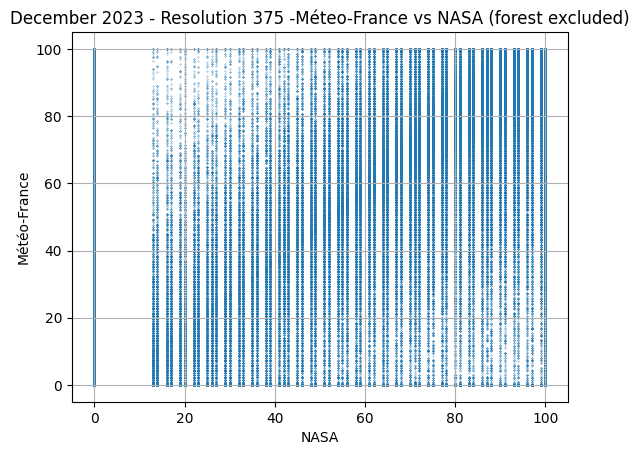

In [2]:
meteofrance = meteofrance_time_series.sel(time=common_days).sel(time='2023-12')
nasa = nasa_pseudo_l3_time_series.sel(time=common_days).sel(time='2023-12')
meteofrance_mask = meteofrance.data_vars['snow_cover_fraction']<=200
nasa_mask = nasa.data_vars['snow_cover_fraction']<=100
union_mask = meteofrance_mask & nasa_mask
meteofrance = meteofrance.data_vars['snow_cover_fraction'].where(union_mask) /2
nasa = nasa.data_vars['snow_cover_fraction'].where(union_mask)

fig, ax = plt.subplots()
ax.scatter(nasa, meteofrance, s=0.05)
ax.set_xlabel('NASA')
ax.set_ylabel('Météo-France')
ax.grid(True)
ax.set_title(f'December 2023 - Resolution {resolution} - Méteo-France vs NASA (forest excluded)')